#### Importando bibliotecas necessárias

In [4]:
import sys
import polars as pl
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import math

sys.path.append('D:\\__case_ifood\\notebooks\\utils') # Defina aqui a pasta


In [10]:
from utils import get_sales_data

### A) Mensurando o sucesso da campanha

##### Serão consideradas as seguintes métricas de avaliação do Teste A/B

##### 1. ARPU (Average Revenue per User)

**Definição**:  
Mede a média de receita gerada por usuário em um determinado período. Essa métrica permite avaliar o impacto da variação testada na monetização dos usuários.

**Fórmula**:  
```
ARPU = Receita Total / Número de Usuários
```

**Objetivo no teste A/B**:  
Verificar se a variação testada resulta em um aumento significativo na receita média por usuário em comparação ao grupo de controle.

---

##### 2. Engajamento (Recompra)

**Definição**:  
Mede o percentual de usuários que realizaram pelo menos uma nova compra após a primeira interação. Essa métrica reflete o nível de retorno e fidelização dos clientes.

**Fórmula**:  
```
Engajamento = (Usuários com Recompra / Total de Usuários) × 100
```

**Objetivo no teste A/B**:  
Avaliar se a variação testada aumenta a taxa de clientes que retornam e realizam novas compras em relação ao grupo de controle.

#### Métrica ARPU

In [27]:
# Importando o dataset de vendas
df_sales = get_sales_data()

In [28]:
# Create DF to evaluation metrics

df_evaluation_metrics = df_sales.group_by("is_target").agg([
    pl.col("order_id").n_unique().alias("orders"),
    pl.col("customer_id").n_unique().alias("unique_customers"),
    pl.col("amount").sum().alias("revenue"),
    (pl.col("amount").sum() / pl.col("order_id").n_unique()).round(2).alias("TKM"),
    (pl.col("amount").sum() / pl.col("customer_id").n_unique()).round(2).alias("ARPU")
]).with_columns([
    pl.col("revenue").sum().alias("total_revenue"),
    pl.col("orders").sum().alias("total_orders"),
    pl.col("unique_customers").sum().alias("total_customers")
]).sort("is_target", descending=True)

In [29]:
# repurchase customers

df_customers_with_2_orders = df_sales.group_by("is_target","customer_id").agg([
    pl.col("order_id").count().alias("orders")
]).filter(pl.col("orders") == 2).group_by("is_target").agg([
    pl.col("customer_id").n_unique().alias("customers_with_2_orders") # clientes_com_2_pedido
])

df_customers_with_3_orders = df_sales.group_by("is_target","customer_id").agg([
    pl.col("order_id").count().alias("orders")
]).filter(pl.col("orders") == 3).group_by("is_target").agg([
    pl.col("customer_id").n_unique().alias("customers_with_3_orders")
])

df_customers_with_3_plus_orders = df_sales.group_by("is_target","customer_id").agg([
    pl.col("order_id").count().alias("orders")
]).filter(pl.col("orders") > 3).group_by("is_target").agg([
    pl.col("customer_id").n_unique().alias("customers_with_3_plus_orders")
])

In [30]:
# Join DFs

df_evaluation_metrics = df_evaluation_metrics.join(
    df_customers_with_2_orders,
    on="is_target",
    how="left"
).with_columns([
    (pl.col("customers_with_2_orders") / pl.col("unique_customers")).round(3).alias("percent_customers_with_2_orders")
]).join(
    df_customers_with_3_orders,
    on="is_target",
    how="left"
).with_columns([
    (pl.col("customers_with_3_orders") / pl.col("unique_customers")).round(3).alias("percent_customers_with_3_orders")
]).join(
    df_customers_with_3_plus_orders,
    on="is_target",
    how="left"
).with_columns([
    (pl.col("customers_with_3_plus_orders") / pl.col("unique_customers")).round(3).alias("percent_customers_with_3_plus_orders")
]
)

In [31]:
# Calculate difference between ARPU customers target and customers control

diff_arpu = df_evaluation_metrics.filter(pl.col("is_target") == "target")["ARPU"].item() - df_evaluation_metrics.filter(pl.col("is_target") == "control")["ARPU"].item()
print(round(diff_arpu,2))
percent_diff_arpu = (df_evaluation_metrics.filter(pl.col("is_target") == "target")["ARPU"].item() - df_evaluation_metrics.filter(pl.col("is_target") == "control")["ARPU"].item()) / df_evaluation_metrics.filter(pl.col("is_target") == "control")["ARPU"].item()
print(round(percent_diff_arpu,3))

17.56
0.131


In [32]:
# Calculating Cohen's d statistic for ARPU to measure effect size
# Cohen's d is a measure of effect size that indicates the difference between two means in terms of standard deviations.
# It is calculated as the difference between the means divided by the pooled standard deviation.

arpu_target = df_evaluation_metrics.filter(pl.col("is_target") == "target")["ARPU"].item()
arpu_control = df_evaluation_metrics.filter(pl.col("is_target") == "control")["ARPU"].item()

df_std_arpu = df_sales.group_by("customer_id","is_target").agg([
    pl.col("amount").sum().alias("total_gasto")
]).group_by("is_target").agg([
    pl.col("total_gasto").std().alias("std_arpu")
])
std_target = df_std_arpu.filter(pl.col("is_target") == "target")["std_arpu"].item()
std_control = df_std_arpu.filter(pl.col("is_target") == "control")["std_arpu"].item()

cohen_d = round((arpu_target - arpu_control) / (math.sqrt(((std_target**2 + std_control**2) / 2))),5)

print(f"Cohen's d: {cohen_d}")

Cohen's d: 0.06354


##### Resultado: ARPU (Average Revenue Per User)

Para avaliar o impacto financeiro da campanha, utilizamos o índice **Cohen's d**, que mede o **tamanho do efeito** entre dois grupos. A interpretação do resultado é baseada na seguinte referência:

###### Interpretação do Tamanho do Efeito (Cohen's d)

- **Muito Pequeno** 0.0 a 0.19
- **Pequeno**: 0.2 a 0.49  
- **Médio**: 0.5 a 0.79  
- **Grande**: 0.8 ou mais  

---

##### Conclusão

O ARPU no grupo teste foi **R$ 17,55 maior**, representando um aumento de **13%** em relação ao grupo controle.

Embora o tamanho do efeito estatístico seja **pequeno**, a diferença prática pode ser **financeiramente relevante**, especialmente se o custo médio do cupom for inferior ao ganho adicional por cliente.

Essa análise sugere que a campanha **teve impacto positivo na receita média por usuário**, e sua viabilidade depende do custo-benefício entre o valor do cupom e o retorno incremental.


#### Engajamento (Recompra)

shape: (2, 4)
┌───────────┬────────────────────────────┬────────────────────────────┬────────────────────────────┐
│ is_target ┆ percent_customers_with_2_o ┆ percent_customers_with_3_o ┆ percent_customers_with_3_p │
│ ---       ┆ rder…                      ┆ rder…                      ┆ lus_…                      │
│ str       ┆ ---                        ┆ ---                        ┆ ---                        │
│           ┆ f64                        ┆ f64                        ┆ f64                        │
╞═══════════╪════════════════════════════╪════════════════════════════╪════════════════════════════╡
│ target    ┆ 0.203                      ┆ 0.111                      ┆ 0.262                      │
│ control   ┆ 0.167                      ┆ 0.091                      ┆ 0.218                      │
└───────────┴────────────────────────────┴────────────────────────────┴────────────────────────────┘


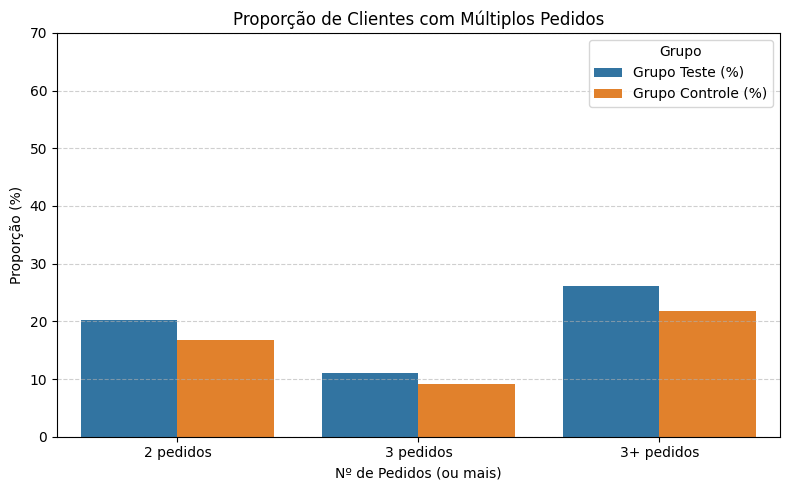

In [47]:
print(
    (
    df_evaluation_metrics.select(
        pl.col("is_target"),
        pl.col("percent_customers_with_2_orders"),
        pl.col("percent_customers_with_3_orders"),
        pl.col("percent_customers_with_3_plus_orders")
     )
    )
)


# Dados de proporção por critério
datas = {
    "Critério": ["2 pedidos", "3 pedidos", "3+ pedidos"],
    "Grupo Teste (%)": [20.3, 11.1, 26.2],
    "Grupo Controle (%)": [16.7, 9.1, 21.8]
}

# Criar DataFrame
df = pd.DataFrame(datas)

# Reestruturar o DataFrame para formato longo (long format)
df_melted = df.melt(id_vars="Critério", 
                    var_name="Grupo", 
                    value_name="Proporção (%)")

# Tamanho do gráfico
plt.figure(figsize=(8, 5))

# Criar gráfico de barras
sns.barplot(data=df_melted, x="Critério", y="Proporção (%)", hue="Grupo")

# Personalizações
plt.title("Proporção de Clientes com Múltiplos Pedidos")
plt.ylim(0, 70)
plt.ylabel("Proporção (%)")
plt.xlabel("Nº de Pedidos (ou mais)")
plt.legend(title="Grupo")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()

# Mostrar gráfico
plt.show()

In [48]:
percent_customers_with_2_orders_target = df_evaluation_metrics.filter(pl.col("is_target") == "target")["percent_customers_with_2_orders"].item()
percent_customers_with_2_orders_control = df_evaluation_metrics.filter(pl.col("is_target") == "control")["percent_customers_with_2_orders"].item()
two_orders = round((percent_customers_with_2_orders_target / percent_customers_with_2_orders_control) - 1,3)
print(f"Customers with 2 orders diff percentage: {two_orders}")

percent_customers_with_3_orders_target = df_evaluation_metrics.filter(pl.col("is_target") == "target")["percent_customers_with_3_orders"].item()
percent_customers_with_3_orders_control = df_evaluation_metrics.filter(pl.col("is_target") == "control")["percent_customers_with_3_orders"].item()
three_orders = round((percent_customers_with_3_orders_target / percent_customers_with_3_orders_control) - 1,3)
print(f"Customers with 3 orders diff percentage: {three_orders}")

percent_customers_with_3_plus_orders_target = df_evaluation_metrics.filter(pl.col("is_target") == "target")["percent_customers_with_3_plus_orders"].item()
percent_customers_with_3_plus_orders_control = df_evaluation_metrics.filter(pl.col("is_target") == "control")["percent_customers_with_3_plus_orders"].item()
three_plus_orders = round((percent_customers_with_3_plus_orders_target / percent_customers_with_3_plus_orders_control) - 1,3)
print(f"Customers with 3 orders diff percentage: {three_plus_orders}")

Customers with 2 orders diff percentage: 0.216
Customers with 3 orders diff percentage: 0.22
Customers with 3 orders diff percentage: 0.202


#### Resultado Engajamento

A campanha de cupom resultou em um **aumento consistente de aproximadamente 20%** na proporção de clientes que realizaram múltiplos pedidos, independentemente do critério considerado:

- **2 pedidos**: 20,3% (teste) vs 16,3% (controle)  
- **3 pedidos**: 11,1% (teste) vs 9,1% (controle)  
- **3+ pedidos**: 26,2% (teste) vs 21,8% (controle)  

Essa consistência indica que o cupom não apenas incentivou a **primeira recompra**, mas também gerou **maior engajamento contínuo** com a plataforma, promovendo **comportamentos de recompra recorrentes**.


### b) Análise de Viabilidade Financeira da Campanha

Nesta seção, avaliamos se a campanha de cupom foi financeiramente viável como estratégia de crescimento. Para isso, foram adotadas as seguintes premissas:

---

#### Premissas

| Premissa                                      | Valor / Descrição                     |
|----------------------------------------------|----------------------------------------|
| **Clientes no grupo teste**                  | 445.924                                |
| **Aumento de ARPU (R$)**                     | R$ 17,55                                |
| **Custo médio do cupom por cliente**         | R$ 15,00 *(estimado)*                 |
| **% de clientes que usaram o cupom**         | 100% *(pior cenário para viabilidade)* |
| **% de clientes que tiveram recompra**         | 20% *(baseado na análise de engajamento)* |
| **Período analisado**                        | Dez/2018 a Jan/2019 (2 meses)          |

---

#### Receita adicional estimada - 1º onda:

> **445.924 clientes × R$ 17,55 = R$ 7.822.967**

#### Custo estimado da campanha - 1º onda:

> **445.924 clientes × R$ 15 = R$ 6.688.860 (Não estou considerando demais custos. E.g: logistica, operacional, etc.)**

#### Lucro incremental estimado - 1º onda:

> **R$ 7.822.967 - R$ 6.688.860 = R$ 1.134.107**

---

### Análise de Cenários (Adesão ao cupom)

| % de adesão ao cupom | Receita Estimada | Custo Estimado | Lucro Estimado |
|----------------------|------------------|----------------|----------------|
| 100% (pior cenário)     | R$ 7,82 milhões  | R$ 6,68 milhões| R$ 1,13 milhão |
| 75%                  | R$ 5,87 milhões  | R$ 5,02 milhões| R$ 843 mil     |
| 50%                  | R$ 3,91 milhões  | R$ 3,34 milhões| R$ 567 mil     |
| 25%                  | R$ 1,95 milhões  | R$ 1,67 milhões| R$ 283 mil     |

---

### Agora vamos considerar o cenário que 20% dos clientes retornam para fazer uma segunda compra

#### Receita adicional estimada - 2º onda:

> **89.185 clientes (20% - considerando o pior cenário) × R$ 17,55 = R$ 1.565.196**

#### Custo estimado da campanha - 2º onda:

> **89.185 clientes (20%) × R$ 0,00 = R$ 0,00 (Não estou considerando demais custos. E.g: logistica, operacional, etc.)** 

#### Lucro incremental estimado - 2º onda:

> **R$ 1.565.196 - R$ 0,00 = R$ 1.565.196**

#### Lucro total entre a 1º e 2º onda:

> **R$ 1.134.107 + R$ 1.565.196 = R$ 2.699.303**

### Conclusão

> Mesmo com um efeito estatístico pequeno no ARPU (Cohen’s d ≈ 0,065), o impacto financeiro agregado foi positivo.  
> A campanha mostra-se **viável financeiramente** mesmo em cenários conservadores de adesão ao cupom, e se apresenta como uma **alavanca de crescimento escalável** para o iFood.

### C) Proposta de melhoria e novo teste A/B

#### Principais aprendizados do teste atual

- A campanha de cupons gerou um aumento positivo no ARPU médio (~13%) e engajamento geral (~57% dos clientes fizeram mais de 1 pedido).
- O tamanho do efeito estatistico não foi relevante, porém o ganho financeiro obtido nas estimativas garantem que há oportunidade de melhorias no teste e obtermos maior retorno financeiro.

---

#### Hipóteses para melhorias

1. **Segmentação por região**: regiões com maior impacto devem receber maiores investimentos promocionais.
2. **Segmentação por comportamento passado**: clientes novos ou pouco engajados podem responder melhor a cupons agressivos.
3. **Ajuste de valor do cupom**: testar diferentes valores para entender elasticidade de resposta por perfil.
4. **Duração da campanha**: testar impactos de promoções contínuas vs. limitadas (urgência).
5. **Canais de ativação**: verificar se houve variação de impacto por plataforma de origem (ex: mobile vs. web).

---

#### Nova proposta de teste A/B

**Objetivo:** Otimizar a efetividade dos cupons, personalizando por perfil e local.

| Elemento                  | Novo Design                                                  |
|---------------------------|--------------------------------------------------------------|
| **População elegível**    | Clientes ativos nas últimas 12 semanas                      |
| **Segmentação**           | Por cidade **e** perfil de engajamento                      |
| **Grupos**                | Controle (sem cupom), Cupom padrão, Cupom personalizado     |
| **Duração**               | 2 a 3 semanas                                                |
| **Cupom personalizado**   | Valor ajustado por cidade e frequência de uso               |
| **Métricas principais**   | ARPU, % com 2+ e 3+ pedidos, % reativação de inativos       |
| **Métricas secundárias**  | Retorno por R$ investido, Churn 30 dias após campanha       |

---

### Benefícios esperados

- **Maximização do ROI** com cupons direcionados.
- **Melhor alocação de verba promocional** em regiões com maior resposta.
- **Identificação de perfis mais sensíveis a cupons**, para uso futuro em outras ações (como reativação de inativos).
